In [1]:
import re
import string

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from typing import List
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# EDA

In [2]:
df = pd.read_csv('data/transformed_wiki_data.csv', header=0)
df.head()

,id,title,text,generated
0,63064638,Sexhow railway station,Sexhow railway station was a railway station b...,0
1,18704707,Sexhow railway station,Sexhow railway station was a railway station l...,1
2,279621,Etiäinen,"In Finnish folklore, all places and things, an...",0
3,58254742,Etiäinen,"In Finnish folklore, all places and things, an...",1
4,287229,Inverse function theorem,"In mathematics, specifically differential calc...",0


In [3]:
df.shape

(300000, 4)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   id         300000 non-null  int64 
 1   title      300000 non-null  object
 2   text       300000 non-null  object
 3   generated  300000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 9.2+ MB


In [5]:
df.isna().sum()

id           0
title        0
text         0
generated    0
dtype: int64

In [6]:
df['title'].nunique()

150000

The dataframe consists of 4 columns and 300 000 rows. The columns are:
- `id` - [Dtype: integer] - id of the text
- `title` - [Dtype: string] - title of the text
- `text` - [Dtype: string] - raw content of the text
- `generated` - [Dtype: integer] - the target class representing information about if the text was generated by a large language model (LLM) or not. The values of the column are 1 if the text was generated by LLM and 0 if the text was written by a human (not generated by a LLM).

The dataframe doesn't contain null values. It contains 150 000 texts written by humans and 150 000 texts of the same titles generated by a LLM.

Let's take a look at the number of characters in each text.

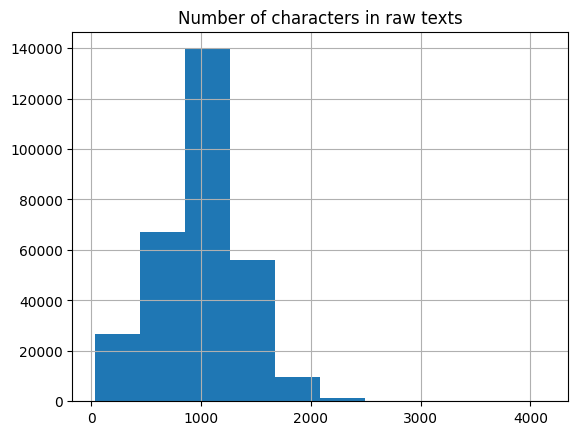

In [10]:
df['text'].str.len().hist()
plt.title('Number of characters in raw texts')
plt.show()

Let's take a look at the number of tokens in each text.

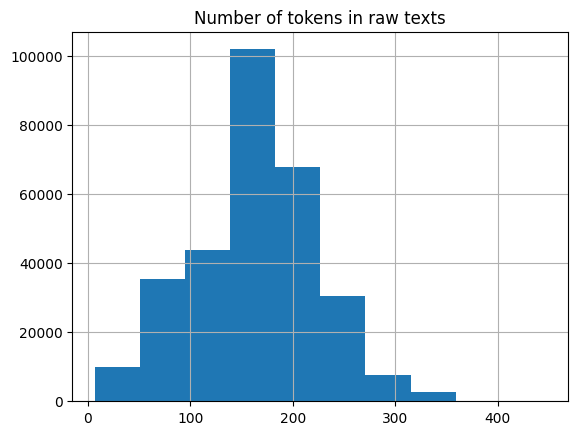

In [11]:
df['text'].str.split().str.len().hist()
plt.title('Number of tokens in raw texts')
plt.show()

Let's take a look at the average word length per text.

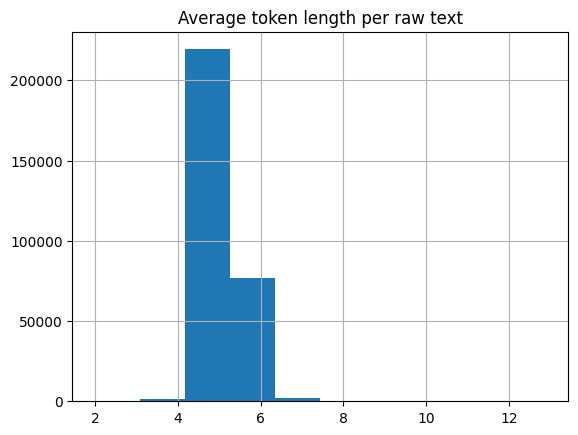

In [13]:
df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.title('Average token length per raw text')
plt.show()

In [3]:
stop_words = set(nltk.corpus.stopwords.words('english'))

In [3]:
raw_corpus = []
raw_texts_by_words = [text.split() for text in df['text'].tolist()]
raw_corpus = [word.lower() for text in raw_texts_by_words for word in text]

print(len(raw_corpus), raw_corpus[0])

48981862 sexhow


In [18]:
stopw_cnt = dict.fromkeys(stop_words, 0)
for word in raw_corpus:
    word = word.lower().strip()
    if word in stop_words:
        stopw_cnt[word] += 1

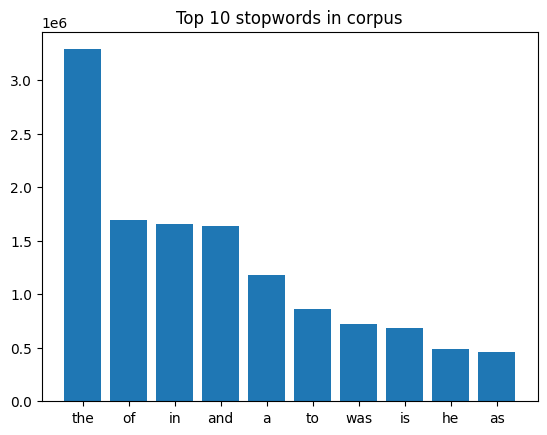

In [19]:
stopw_sorted = sorted(stopw_cnt, key=stopw_cnt.get, reverse=True)
stopw_sorted_vals = [stopw_cnt[word] for word in stopw_sorted]
plt.bar(stopw_sorted[:10], stopw_sorted_vals[:10])
plt.title('Top 10 stopwords in raw corpus')
plt.show()

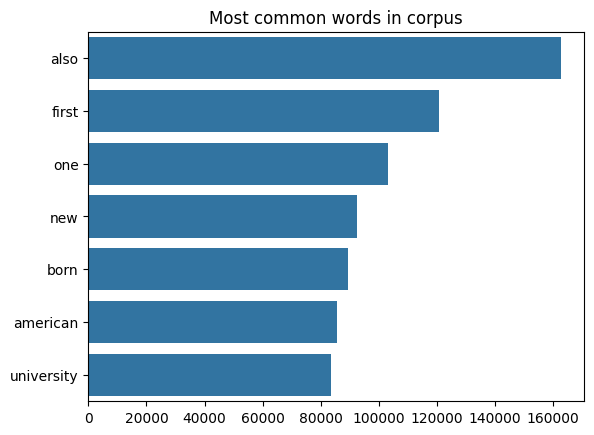

In [21]:
counter = Counter(raw_corpus)
most = counter.most_common()

x, y= [], []
for word, count in most[:40]:
    if (word not in stop_words):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)
plt.title('Most common words in corpus')
plt.show()

Let's analyze ngrams.

In [19]:
def get_ngrams(corpus: List[str], ngram_from=2, ngram_to=2, n=None):
    
    vec = CountVectorizer(ngram_range = (ngram_from, ngram_to)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis = 0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
   
    return words_freq[:n]

In [25]:
raw_bigrams = get_ngrams(raw_corpus, ngram_from=2, ngram_to=2, n=10)

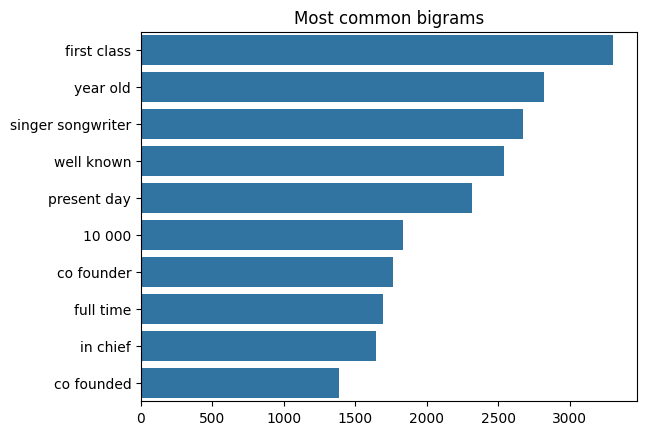

In [26]:
ngrams = [b[0] for b in raw_bigrams]
ngrams_cnt = [b[1] for b in raw_bigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common bigrams')
plt.show()

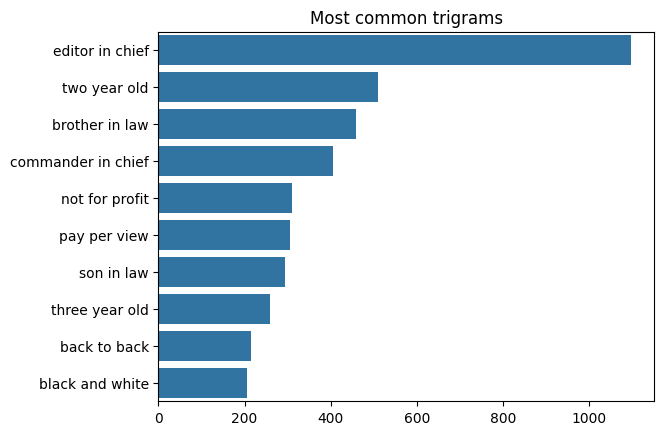

In [27]:
raw_trigrams = get_ngrams(raw_corpus, ngram_from=3, ngram_to=3, n=10)

ngrams = [b[0] for b in raw_trigrams]
ngrams_cnt = [b[1] for b in raw_trigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common trigrams')
plt.show()

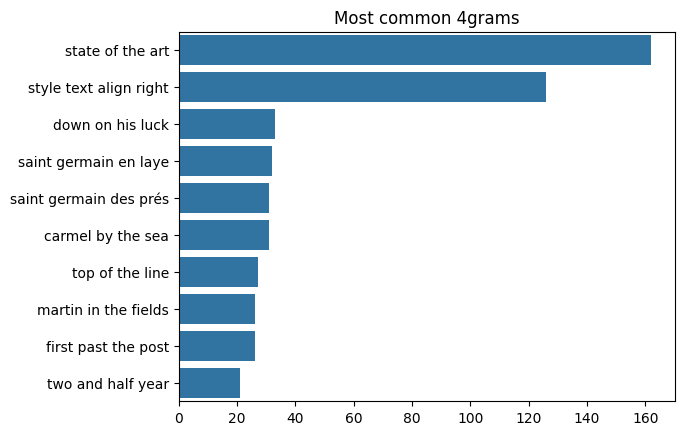

In [28]:
raw_4grams = get_ngrams(raw_corpus, ngram_from=4, ngram_to=4, n=10)

ngrams = [b[0] for b in raw_4grams]
ngrams_cnt = [b[1] for b in raw_4grams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common 4grams')
plt.show()

## Wordcloud

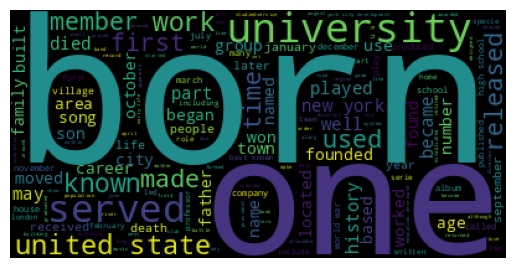

In [31]:
wordcloud = WordCloud().generate(" ".join(raw_corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# Preprocessing

In [4]:
def cleanText(text):
    text = text.lower()

    # Remove links
    text = re.sub(r"http\S*|\S*\.com\S*|\S*www\S*", " ", text)

    # Remove @mentions
    text = re.sub(r"\s@\S+", " ", text)

    # Remove all punctuation
    punctuation_table = str.maketrans("", "", string.punctuation)
    text = text.translate(punctuation_table)

    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)

    # Tokenize
    tokens = word_tokenize(text)

    # Remove 
    stop_words = set(nltk.corpus.stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    tokens = [token for token in tokens if len(token) > 2]

    return tokens

In [5]:
texts_by_words = []
for text in df['text']:
    texts_by_words.append(cleanText(text))

In [6]:
corpus = []
for text in texts_by_words:
    corpus.extend(text)

# EDA After Preprocessing

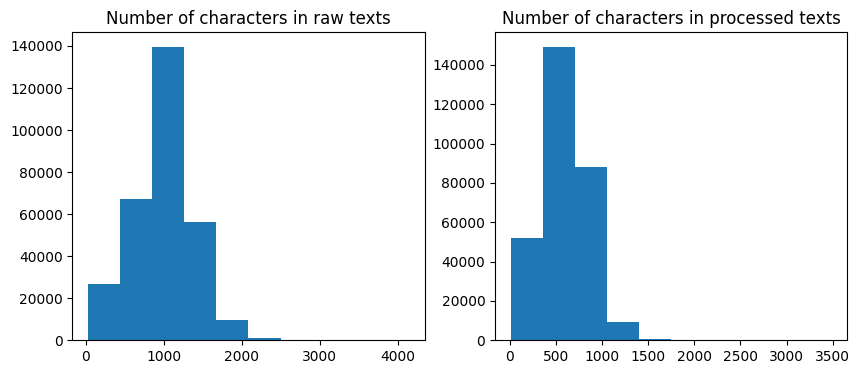

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['text'].str.len().hist()
plt.grid(False)
plt.title('Number of characters in raw texts')

plt.subplot(1, 2, 2)
nr_chars_per_text = np.zeros(len(texts_by_words))
for i in range(len(texts_by_words)):
    for token in texts_by_words[i]:
        nr_chars_per_text[i] += len(token)
plt.hist(nr_chars_per_text)
plt.grid(False)
plt.title('Number of characters in processed texts')
plt.show()

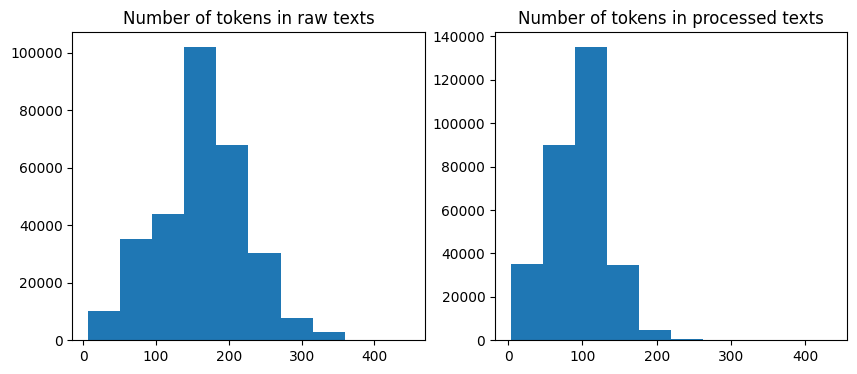

In [8]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['text'].str.split().str.len().hist()
plt.grid(False)
plt.title('Number of tokens in raw texts')

plt.subplot(1, 2, 2)
text_lenghts = [len(text) for text in texts_by_words]
plt.hist(text_lenghts)
plt.title('Number of tokens in processed texts')
plt.show()

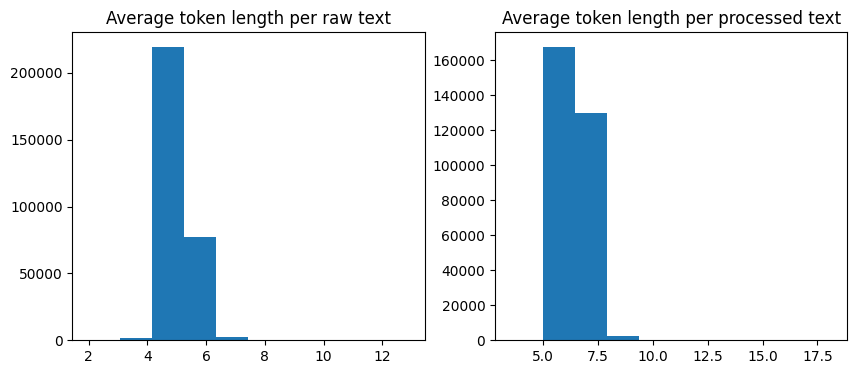

In [11]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()
plt.grid(False)
plt.title('Average token length per raw text')

plt.subplot(1, 2, 2)
token_lenghts = []
for text in texts_by_words:
    token_lenghts.append([len(token) for token in text])
avg_token_lenghts = [np.mean(lenghts) for lenghts in token_lenghts]
plt.hist(avg_token_lenghts)
plt.title('Average token length per processed text')
plt.show()

In [14]:
def get_most_common_words(corpus):
    counter = Counter(corpus)
    most = counter.most_common()

    x, y= [], []
    for word, count in most[:40]:
        if (word not in set(nltk.corpus.stopwords.words('english'))):
            x.append(word)
            y.append(count)
    return x, y

In [15]:
x_raw, y_raw = get_most_common_words(raw_corpus)
x, y = get_most_common_words(corpus)

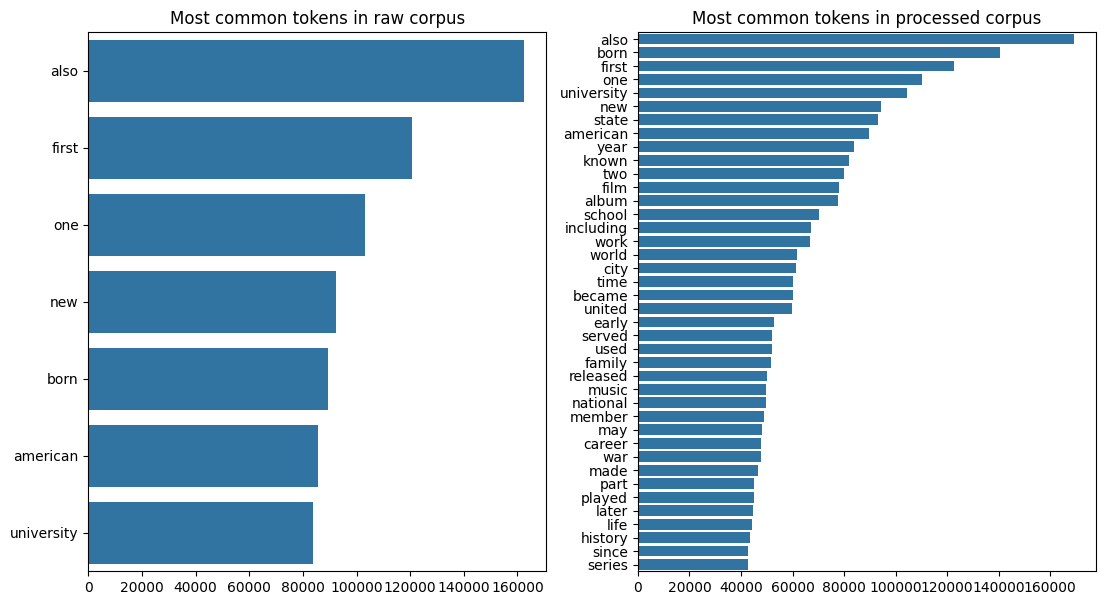

In [18]:
plt.figure(figsize=(13, 7))
plt.subplot(1, 2, 1)
sns.barplot(x=y_raw,y=x_raw)
plt.title('Most common tokens in raw corpus')

plt.subplot(1, 2, 2)
sns.barplot(x=y,y=x)
plt.title('Most common tokens in processed corpus')
plt.show()

In [21]:
raw_bigrams = get_ngrams(raw_corpus, ngram_from=2, ngram_to=2, n=10)
processed_bigrams = get_ngrams(corpus, ngram_from=2, ngram_to=2, n=10)

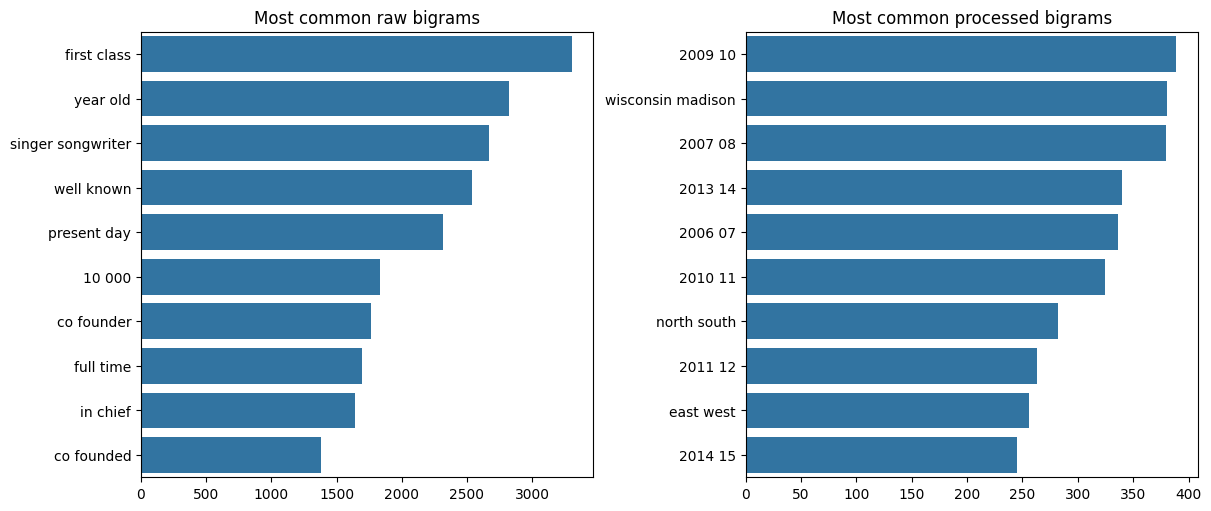

In [30]:
plt.figure(figsize=(12, 5), constrained_layout=True)
plt.subplot(1, 2, 1)
ngrams = [b[0] for b in raw_bigrams]
ngrams_cnt = [b[1] for b in raw_bigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common raw bigrams')

plt.subplot(1, 2, 2)
ngrams = [b[0] for b in processed_bigrams]
ngrams_cnt = [b[1] for b in processed_bigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common processed bigrams')
plt.show()

In [31]:
raw_triigrams = get_ngrams(raw_corpus, ngram_from=3, ngram_to=3, n=10)
processed_trigrams = get_ngrams(corpus, ngram_from=3, ngram_to=3, n=10)

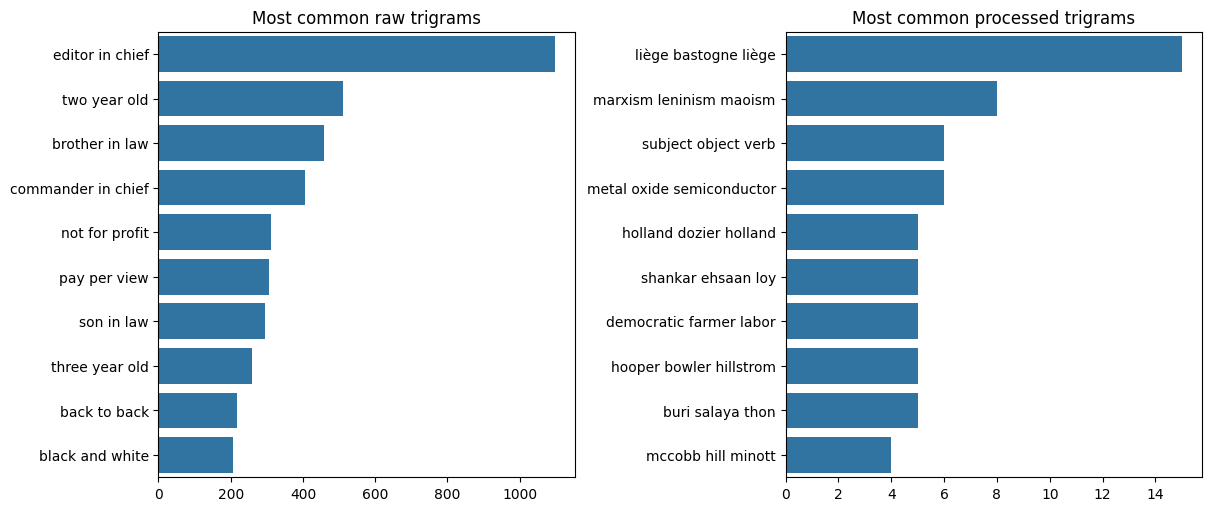

In [32]:
plt.figure(figsize=(12, 5), constrained_layout=True)
plt.subplot(1, 2, 1)
ngrams = [b[0] for b in raw_triigrams]
ngrams_cnt = [b[1] for b in raw_triigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common raw trigrams')

plt.subplot(1, 2, 2)
ngrams = [b[0] for b in processed_trigrams]
ngrams_cnt = [b[1] for b in processed_trigrams]
sns.barplot(x=ngrams_cnt, y=ngrams)
plt.title('Most common processed trigrams')
plt.show()

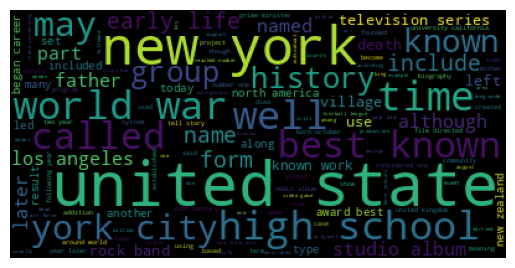

In [7]:
wordcloud = WordCloud().generate(" ".join(corpus))

plt.figure()
plt.imshow(wordcloud)
plt.axis('off')
plt.show()